In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard library imports
import sys
import os
import json

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import shap
from IPython.display import display

# Matplotlib utilities
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set pandas display options
pd.set_option("display.max_rows", 200)

# Define file location
PY_FILE_LOC = os.getcwd()

# Project-specific utility imports
from utils.japan_admin_data import (
    prefecture_dict_jp_to_en,
    japanadmin_muni_all_jp_to_en,
)

from utils.nbutils_load_data import (
    load_and_process_data,
    build_df_for_analysis,
    get_scale_param,
)
from utils.nbutils_cluster_stats import (
    align_spacing,
    format_mean_std,
    get_pref_muni_isin,
    get_cluster_actual_stats,
)
from utils.nbutils_corr import vars_iv_rename_cols
from utils.savefig import savefig_template
from utils.nbutils_shap import plot_feature_importance_base

# Modeling imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [3]:
# load the config
config_fn = os.path.join(PY_FILE_LOC, "config.json")
if os.path.exists(config_fn):
    with open(config_fn) as config_file:
        config = json.load(config_file)
else:
    config = dict()

SAVE_FLAG = bool(config.get("save_figure"))
FIG_BASE_FOLDER = os.path.join(PY_FILE_LOC, "fig")
if not os.path.exists(FIG_BASE_FOLDER):
    os.mkdir(FIG_BASE_FOLDER)

def savefig(fig, fn, **kwargs):
    return savefig_template(SAVE_FLAG, FIG_BASE_FOLDER, fig, fn, **kwargs)

In [4]:
ftr_pref_muni = ["pref", "muni"]
ftr_year_pref_muni = ["year", "pref", "muni"]
pv_types = ["PV_R", "PV_S"]
folder = os.path.join(PY_FILE_LOC, "data")
pv_params, df = load_and_process_data(folder)

pv_cols = dict()
for pv_type in pv_types:
    pv_cols[pv_type] = pv_params.filter(regex=f"^{pv_type}").columns.tolist()

scale_param = get_scale_param()

print(pv_params.filter(regex="^land_").sum().div(1_000_000))
print(pv_params.columns)
print(df.columns)

land_total        37.295617
land_habitable    12.293681
land_buildings     1.746126
land_agri          4.325727
land_avail         6.221828
dtype: float64
Index(['pref', 'muni', 'demand', 'land_total', 'land_habitable',
       'land_buildings', 'land_agri', 'taxable_income', 'LV', 'LV_2014',
       'LV_2015', 'LV_2016', 'LV_2017', 'LV_2018', 'LV_2019', 'LV_2020',
       'LV_2021', 'LV_2022', 'LV_2023', 'PV_R_2014', 'PV_R_2015', 'PV_R_2016',
       'PV_R_2017', 'PV_R_2018', 'PV_R_2019', 'PV_R_2020', 'PV_R_2021',
       'PV_R_2022', 'PV_R_2023', 'PV_S_2014', 'PV_S_2015', 'PV_S_2016',
       'PV_S_2017', 'PV_S_2018', 'PV_S_2019', 'PV_S_2020', 'PV_S_2021',
       'PV_S_2022', 'PV_S_2023', 'PV_M_2014', 'PV_M_2015', 'PV_M_2016',
       'PV_M_2017', 'PV_M_2018', 'PV_M_2019', 'PV_M_2020', 'PV_M_2021',
       'PV_M_2022', 'PV_M_2023', 'PV_U_2014', 'PV_U_2015', 'PV_U_2016',
       'PV_U_2017', 'PV_U_2018', 'PV_U_2019', 'PV_U_2020', 'PV_U_2021',
       'PV_U_2022', 'PV_U_2023', 'pv_out', 'epco', 

## PV Type Specific

Do not change vars_dv from this point onwards

In [5]:
vars_dv = "PV_S"
no_outlier = True

In [6]:
# focus on the no outlier
if no_outlier:
	outlier_filename = os.path.join(PY_FILE_LOC, "data", "pv_growth_outlier.csv")
	outlier_summary = pd.read_csv(outlier_filename)
	outlier_index = outlier_summary[ftr_pref_muni].apply(tuple, axis=1).to_list()

	pv_param_no_outliers = pv_params[
        ~(pv_params[ftr_pref_muni].apply(tuple, axis=1).isin(outlier_index))
    ]
	pv_param_outliers = pv_params[
        (pv_params[ftr_pref_muni].apply(tuple, axis=1).isin(outlier_index))
    ]
	df = build_df_for_analysis(pv_param_no_outliers)

len(df)

17080

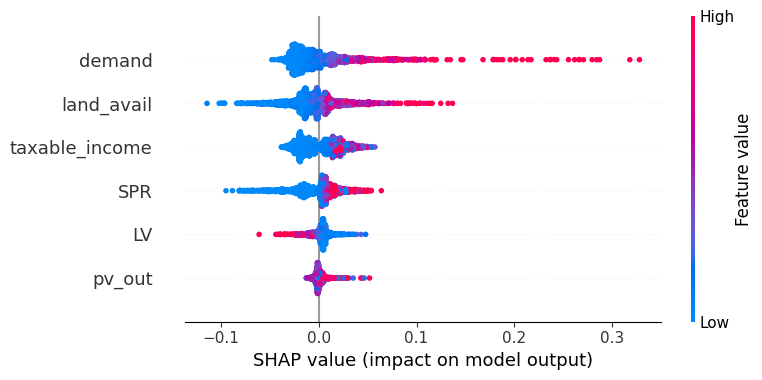

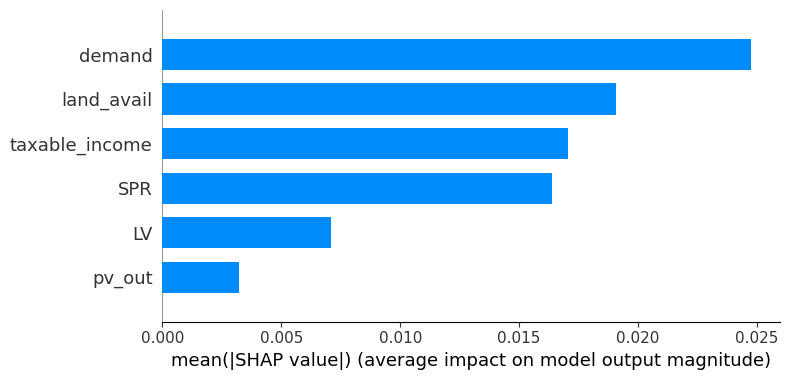

r2: 0.9662937383243688
Normalized SHAP Feature Importance
            demand  land_avail  taxable_income        LV       SPR    pv_out
mean_abs  0.024739    0.019092        0.017074  0.007068  0.016365  0.003200
%         0.282607    0.218096        0.195052  0.080744  0.186951  0.036551


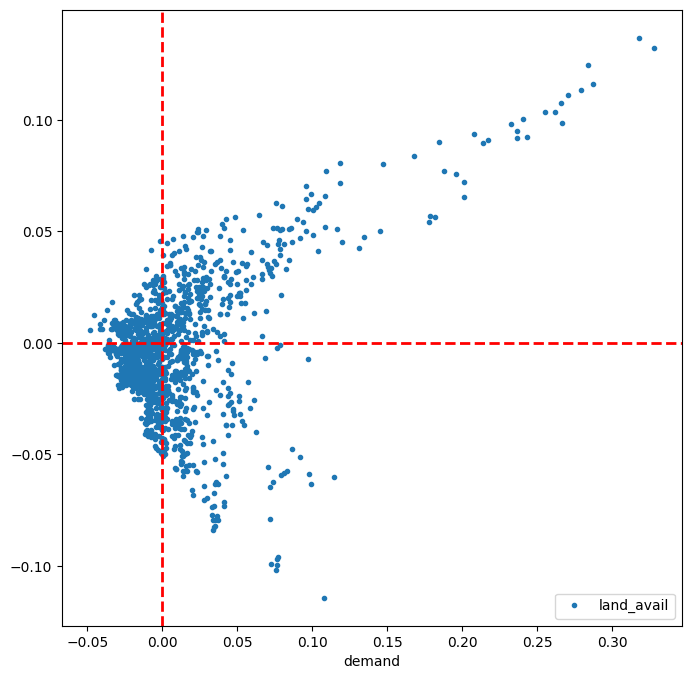

In [7]:
def plot_feature_importance(year):
	return plot_feature_importance_base(df, vars_dv, year)

plot_feature_importance(year=2015)

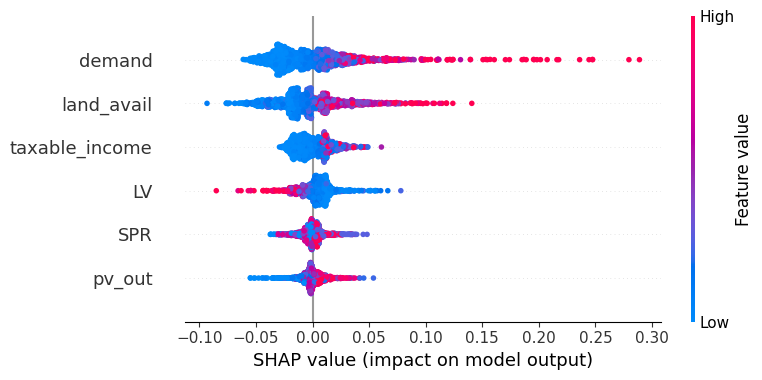

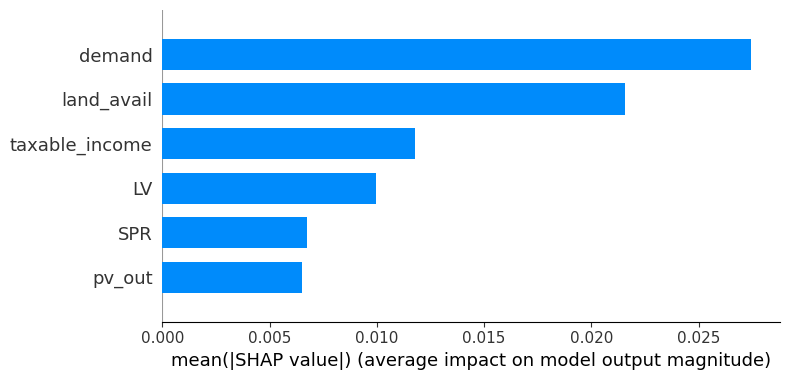

r2: 0.9427812659897512
Normalized SHAP Feature Importance
            demand  land_avail  taxable_income        LV       SPR    pv_out
mean_abs  0.027429    0.021552        0.011781  0.009962  0.006761  0.006503
%         0.326586    0.256604        0.140267  0.118609  0.080504  0.077431


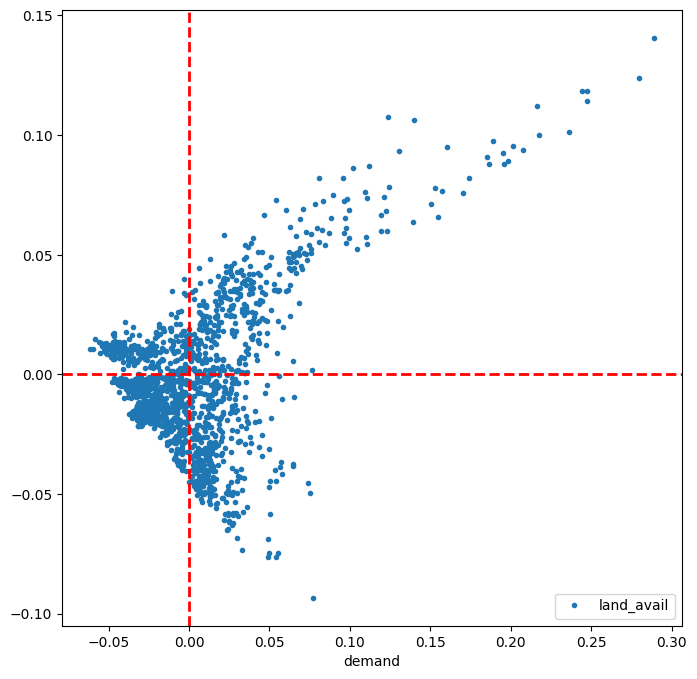

In [8]:
plot_feature_importance(year=2023)

## SHAP Calculations

In [9]:
# ============================================================================ #
# Train
# ============================================================================ #

# select the dependent and independent variables
vars_iv = ["demand", "land_avail", "taxable_income", "LV", "SPR", "pv_out"]

X = df[vars_iv]
y = df[vars_dv]

# train with 40% of the 10-year data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.6, random_state=42
)

# Train the model
model = RandomForestRegressor(random_state=42, n_jobs=16)
model.fit(X_train, y_train)

# calculate the scores
regre_stats = dict()
y_pred = model.predict(X_test)
regre_stats["r2"] = r2_score(y_test, y_pred)
regre_stats["mae"] = mean_absolute_error(y_test, y_pred)
regre_stats["mse"] = mean_squared_error(y_test, y_pred)
regre_stats["rmse"] = np.sqrt(regre_stats["mse"])
print(regre_stats)

# save the model
model_loc = os.path.join(PY_FILE_LOC, "data", f'model_RFR_{vars_dv}.joblib')
joblib.dump(model, model_loc, compress=3)

{'r2': 0.960020526657092, 'mae': 0.00833983628236308, 'mse': 0.00029379735838856285, 'rmse': 0.017140518031511266}


['/home/matthew/GitHub/eds-jp-pv-growth-resi-small/data/model_RFR_PV_S.joblib']

In [10]:
# ============================================================================ #
# Predict and calculate the SHAP values
# ============================================================================ #
year = 2023

df_temp = df[df["year"] == year]

X_sample = df_temp[vars_iv]
y_sample = df_temp[vars_dv]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Predict and calculate residuals
predictions = model.predict(X_sample)
residuals = y_sample - predictions

print("R²", r2_score(predictions, y_sample))

R² 0.962560427102408


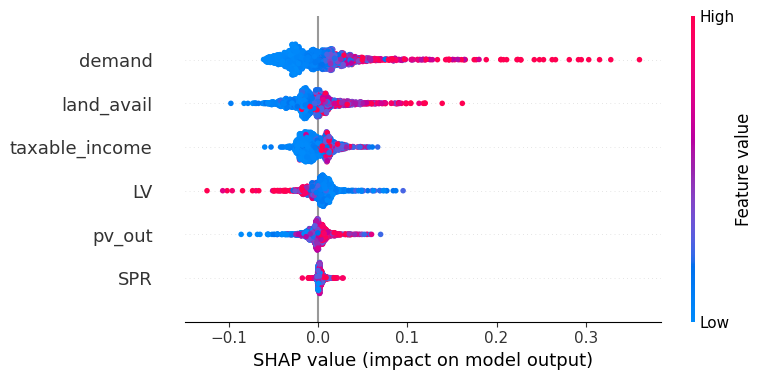

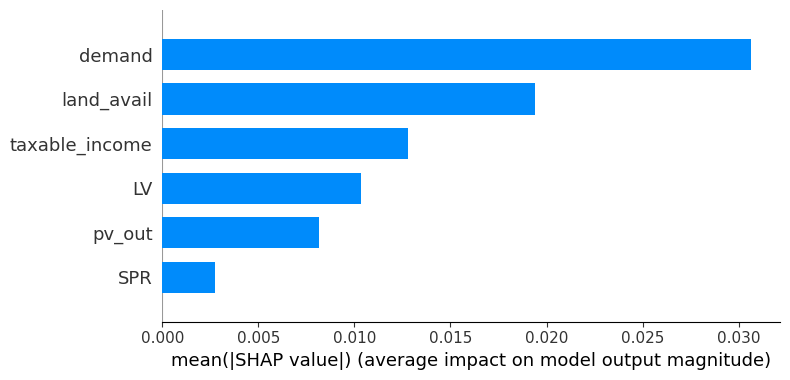

r2: 0.9625604271024085
            demand  land_avail  taxable_income        LV       SPR    pv_out
mean_abs  0.030629    0.019422        0.012800  0.010348  0.002717  0.008167
%         0.364271    0.230991        0.152231  0.123065  0.032308  0.097134


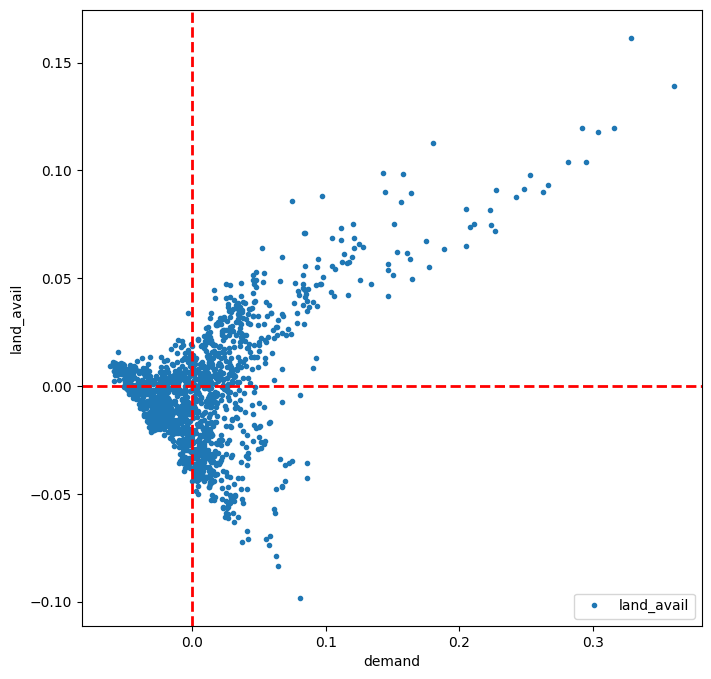

In [11]:
# ============================================================================ #
# PLOTS
# ============================================================================ #

# Summary plot
shap.summary_plot(shap_values, X_sample, feature_names=vars_iv)

# Bar plot to rank feature importance
shap.summary_plot(shap_values, X_sample, plot_type="bar", feature_names=vars_iv)

shap_scores_df = pd.DataFrame(shap_values, columns=vars_iv)

shap_pred = shap_scores_df.sum(axis=1) + explainer.expected_value
print("r2:", r2_score(shap_pred, y_sample))

mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
shap_importance_df = pd.DataFrame.from_dict(
    {"mean_abs": mean_abs_shap_values}, orient="index", columns=vars_iv
)
shap_importance_df.loc["%"] = (
    shap_importance_df.div(shap_importance_df.sum(axis=1), axis=0)
    .loc["mean_abs"]
    .to_dict()
)
shap_var2 = list(
    set(shap_importance_df.T.sort_values("%", ascending=False).head(2).index)
    - {"demand"}
)[0]
print(shap_importance_df)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8)
shap_scores_df.plot(ax=ax, x="demand", y=shap_var2, lw=0, marker=".")
ax.set_ylabel(shap_var2)
ax.axvline(x=0, color="r", linestyle="--", linewidth=2)
ax.axhline(y=0, color="r", linestyle="--", linewidth=2)

In [12]:
# ============================================================================ #
# Summarize the SHAP Scores
# ============================================================================ #

df_temp = shap_scores_df.copy()
df_temp.columns = [c + "_score" for c in df_temp.columns]
shap_score_cols = df_temp.columns

df_sample = df[df["year"] == year].reset_index(drop=True)
df_sample = df_sample[ftr_pref_muni + vars_iv + [vars_dv]]

shap_scores_summary_df = pd.concat([df_sample, df_temp], axis=1)
shap_scores_summary_df[f"{vars_dv}_shap"] = (
    shap_scores_summary_df[shap_score_cols].sum(axis=1) + explainer.expected_value
)
shap_scores_summary_df["pref_en"] = shap_scores_summary_df["pref"].map(
    prefecture_dict_jp_to_en
)
shap_scores_summary_df["muni_en"] = shap_scores_summary_df["muni"].map(
    japanadmin_muni_all_jp_to_en
)

shap_scores_summary_df.head()

,pref,muni,demand,land_avail,taxable_income,LV,SPR,pv_out,PV_S,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_S_shap,pref_en,muni_en
0,北海道,函館市,1181835.0,7161.9990,316463049.0,47153.0,0.104499,1285.006554,0.036365,0.034233,0.009860,-0.012467,-0.006996,0.001035,-0.034603,0.049801,Hokkaido,Hakodate-shi
1,北海道,小樽市,671998.0,6629.7161,126725644.0,24344.0,0.104499,1306.230557,0.004489,0.006944,0.003277,0.002563,-0.005520,0.001808,-0.024103,0.043709,Hokkaido,Otaru-shi
2,北海道,旭川市,1505444.0,15984.9802,422951388.0,26647.0,0.104499,1242.370221,0.014968,0.019812,-0.036301,0.003779,0.004420,0.002633,-0.026476,0.026608,Hokkaido,Asahikawa-shi
3,北海道,室蘭市,867362.0,2203.6117,105103135.0,21932.0,0.104499,1305.760949,0.013718,0.020660,-0.035309,-0.002155,0.006922,-0.000265,-0.010025,0.038568,Hokkaido,Muroran-shi
4,北海道,釧路市,879857.0,17558.0392,210750886.0,20506.0,0.104499,1304.394359,0.143820,0.054114,-0.009875,0.019115,0.009936,0.008848,-0.012599,0.128280,Hokkaido,Kushiro-shi


In [13]:
# ============================================================================ #
# Cluster the SHAP Scores
# ============================================================================ #

columns_for_clustering = [
    "demand_score",
    "land_avail_score",
    "taxable_income_score",
    "LV_score",
    "SPR_score",
    "pv_out_score",
]
X = shap_scores_summary_df[columns_for_clustering]

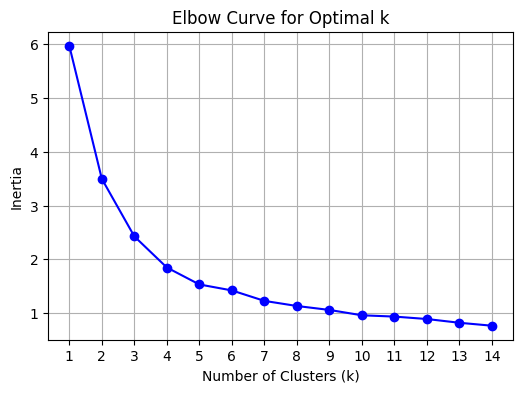

In [14]:
# Define the range of k values to test
k_values = range(1, 15)  
inertia_values = []

# Calculate inertia for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Create the plot using an ax object
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
ax.set_title('Elbow Curve for Optimal k')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Inertia')
ax.set_xticks(k_values)
ax.grid(True)

In [15]:
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
X = shap_scores_summary_df[columns_for_clustering]
shap_scores_summary_df["kmeans_cluster"] = kmeans.fit_predict(X)

# reorder the clustering based on the mean value in the cluster
kmeans_order = (
    shap_scores_summary_df.groupby("kmeans_cluster")[f"{vars_dv}_shap"]
    .mean()
    .sort_values(ascending=False)
    .index.to_list()
)
kmeans_reorder_dict = dict(zip(kmeans_order, range(len(shap_scores_summary_df))))
shap_scores_summary_df["kmeans_cluster"] = shap_scores_summary_df["kmeans_cluster"].map(
    kmeans_reorder_dict
)

# save shap value summary
shap_scores_summary_df.to_csv(
    os.path.join(PY_FILE_LOC, "data", f"shap_values_summary_{vars_dv}.csv"), index=False
)
shap_scores_summary_df.head(3)

,pref,muni,demand,land_avail,taxable_income,LV,SPR,pv_out,PV_S,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_S_shap,pref_en,muni_en,kmeans_cluster
0,北海道,函館市,1181835.0,7161.9990,316463049.0,47153.0,0.104499,1285.006554,0.036365,0.034233,0.009860,-0.012467,-0.006996,0.001035,-0.034603,0.049801,Hokkaido,Hakodate-shi,4
1,北海道,小樽市,671998.0,6629.7161,126725644.0,24344.0,0.104499,1306.230557,0.004489,0.006944,0.003277,0.002563,-0.005520,0.001808,-0.024103,0.043709,Hokkaido,Otaru-shi,4
2,北海道,旭川市,1505444.0,15984.9802,422951388.0,26647.0,0.104499,1242.370221,0.014968,0.019812,-0.036301,0.003779,0.004420,0.002633,-0.026476,0.026608,Hokkaido,Asahikawa-shi,5


In [16]:
# ============================================================================ #
# Random Forest Classifier
# ============================================================================ #

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the dataset
X = shap_scores_summary_df[vars_iv]  # Features
y = shap_scores_summary_df["kmeans_cluster"]  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# save the model
model_loc = os.path.join(PY_FILE_LOC, "data", f'model_RFC_{vars_dv}_{year}.joblib')
joblib.dump(rf_clf, model_loc, compress=3)

Accuracy: 0.83


['/home/matthew/GitHub/eds-jp-pv-growth-resi-small/data/model_RFC_PV_S_2023.joblib']

## Plots

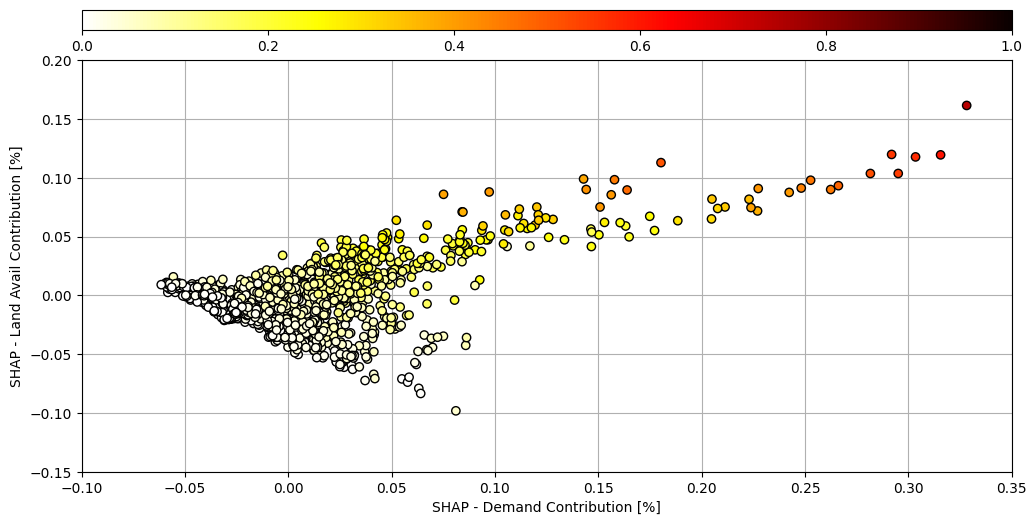

In [17]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 6)

# Create the scatter plot
scatter = ax.scatter(
    x=shap_scores_summary_df["demand_score"],
    y=shap_scores_summary_df[f"{shap_var2}_score"],
    c=shap_scores_summary_df[f"{vars_dv}_shap"],
    cmap="hot_r",
    edgecolor="k",
    vmax=1,
)

# Add color bar
# Create a new axis for the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.3)

# Create the colorbar in the new axis
cbar = plt.colorbar(scatter, cax=cax, label=None, orientation='horizontal')
# cbar.set_ticks(np.arange(len(unique_clusters)))


ax.grid(which="both", axis="both", zorder=0)
ax.set_axisbelow(True)
ylim = {"PV_R": (-0.1, 0.15), "PV_S": (-0.15, 0.20), "PV_M": (-0.1, 0.4)}
xlim = {"PV_R": (-0.2, .8), "PV_S": (-0.10, 0.35), "PV_M": (-0.15, 0.25)}
ax.set_ylim(*ylim[vars_dv])
ax.set_xlim(*xlim[vars_dv])
shap_var2_label = " ".join(shap_var2.split("_")).title()
ax.set_ylabel(f"SHAP - {shap_var2_label} Contribution [%]")
ax.set_xlabel("SHAP - Demand Contribution [%]")

savefig(fig, f'shap_{vars_dv}_solar_cap.svg')

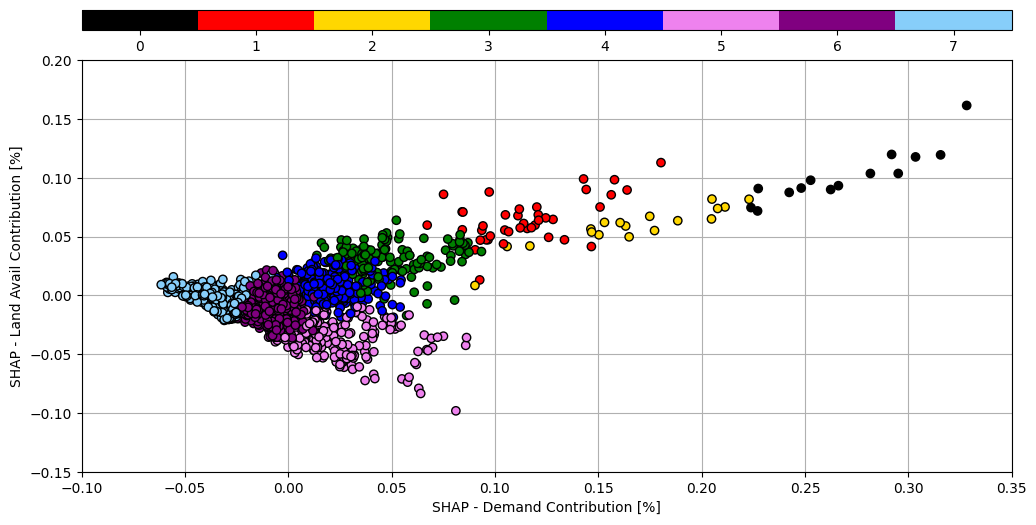

In [18]:
def plot_clusters(ax, df, x_col, y_col, cluster_col, title, colors):
    k = len(shap_scores_summary_df["kmeans_cluster"].unique())
    # Handle NaN values for DBSCAN by assigning a specific value (e.g., -1)
    cluster_values = df[cluster_col].fillna(-1)
    unique_clusters = np.unique(cluster_values)

    # Create a custom color map from the list of colors
    cmap = ListedColormap(colors[: len(unique_clusters)])
    scatter = ax.scatter(
        df[x_col], df[y_col], c=cluster_values, cmap=cmap, marker="o", edgecolor="k"
    )

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(title)

    # Create a new axis for the colorbar
    divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.1)
    cax = divider.append_axes("top", size="5%", pad=0.3)


    # Create the colorbar in the new axis
    ratio = (k-1)/k
    ticks = [c*ratio + ratio/2 for c in range(k)]
    cbar = plt.colorbar(scatter, cax=cax, label=None, orientation='horizontal')
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(range(k))


colors = [
    "k",
    "red",
    "gold",
    "green",
    "blue",
    "violet",
    "purple",
    "lightskyblue",
    "gray",
    "olive",
    "orange",
    "cyan",
]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 6)

plot_clusters(
    ax,
    shap_scores_summary_df,
    "demand_score",
    f"{shap_var2}_score",
    "kmeans_cluster",
    None,
    colors=colors,
)
ax.grid(which="both", axis="both", zorder=0)
ax.set_axisbelow(True)

ax.set_ylim(*ylim[vars_dv])
ax.set_xlim(*xlim[vars_dv])

shap_var2_label = " ".join(shap_var2.split("_")).title()
ax.set_ylabel(f"SHAP - {shap_var2_label} Contribution [%]")
ax.set_xlabel("SHAP - Demand Contribution [%]")
savefig(fig, f'shap_{vars_dv}_cluster.svg')


## Cluster Statistics

In [19]:
# gather the index of the clusters
cluster_index = dict()
for kmean_no, df_g in shap_scores_summary_df.groupby("kmeans_cluster"):
    cluster_index[kmean_no] = df_g[ftr_pref_muni].apply(tuple, axis=1).to_list()

cols_params = f"""
demand_score,4,4
land_avail_score,4,4
taxable_income_score,4,4
LV_score,5,4
SPR_score,5,4
pv_out_score,5,4
{vars_dv}_shap,2,4
{vars_dv},2,4
"""
cols_params = cols_params.strip().split("\n")
cols_params = [c.split(',') for c in cols_params]

score_stats = dict()
for cluster_no, df_cluster in shap_scores_summary_df.groupby("kmeans_cluster"):
	stat_temp = []
	for col, mean_sno, std_sno in cols_params:
		stat_temp.append(format_mean_std(
			df_cluster, col, mean_sno=int(mean_sno), std_sno=int(std_sno), std_per=True
		))
	score_stats[cluster_no] = stat_temp

score_stats = pd.DataFrame(score_stats).T
score_stats.columns = [c[0] for c in cols_params]
score_stats = score_stats.apply(align_spacing, axis=0)
score_stats.columns = [c.replace("_score", "") for c in score_stats.columns]
score_stats = score_stats.rename(columns=vars_iv_rename_cols)
print('SHAP Value Statistics:')
display(score_stats)

df_year = df[df["year"] == year]
scale_param_temp = scale_param.copy()
scale_param_temp.loc[vars_dv] = {'unit': '%',
 'scaler': 1,
 'unit_scaled': '%',
 'mean_sno': 2,
 'std_sno': 2}

print('Actual Statistics:')
display(get_cluster_actual_stats(df_year, cluster_index, scale_param_temp, std_per=True).apply(align_spacing, axis=0).rename(columns=vars_iv_rename_cols))

SHAP Value Statistics:


,DEMAND,LANDAV,TAXIN,LANDVL,PENERT,PVOUT,PV_S_shap,PV_S
0,0.2751 ± 14.8%,0.1042 ± 23.0%,0.0138 ±146.4%,0.05270 ± 55.8%,-0.00122 ±786.9%,0.01009 ±174.4%,0.51 ± 22.7%,0.51 ± 27.9%
1,0.1146 ± 22.5%,0.0643 ± 29.9%,0.0286 ± 64.0%,0.01529 ±108.6%,0.00681 ± 76.4%,0.02930 ± 65.5%,0.32 ± 22.9%,0.34 ± 26.8%
2,0.1661 ± 22.5%,0.0584 ± 29.5%,0.0107 ±144.9%,-0.05153 ± 78.6%,-0.00286 ±160.8%,-0.00546 ±227.1%,0.23 ± 38.0%,0.22 ± 40.4%
3,0.0484 ± 39.7%,0.0309 ± 42.1%,0.0177 ± 59.3%,0.01045 ±181.8%,0.00460 ±104.3%,0.00948 ±135.0%,0.18 ± 20.2%,0.19 ± 26.3%
4,0.0189 ± 65.1%,0.0077 ±145.5%,0.0034 ±358.8%,0.00219 ±516.0%,0.00329 ±136.8%,-0.00691 ±263.4%,0.09 ± 36.7%,0.08 ± 50.0%
5,0.0202 ± 93.6%,-0.0378 ± 34.9%,0.0083 ± 49.4%,-0.01325 ± 84.5%,-0.00012 ±750.0%,-0.00380 ±226.3%,0.03 ± 74.0%,0.03 ± 73.7%
6,-0.0092 ±102.2%,-0.0114 ±100.0%,-0.0081 ±103.7%,0.00155 ±464.5%,0.00238 ±117.6%,-0.00194 ±453.6%,0.03 ± 72.0%,0.03 ± 84.7%
7,-0.0351 ± 28.8%,-0.0052 ±182.7%,-0.0163 ± 34.4%,0.00851 ± 56.4%,0.00237 ± 84.4%,-0.00116 ±525.9%,0.01 ±144.0%,0.01 ±172.0%


Actual Statistics:


,DEMAND,LANDAV,TAXIN,LANDVL,PVOUT,PENERT,PV_S
0,3284 ±44.3%,13070 ± 32.0%,706 ± 60.3%,50 ± 44.0%,1296 ±3.4%,12.77 ±19.2%,0.51 ± 27.5%
1,1144 ±38.1%,7655 ± 37.3%,219 ± 48.4%,37 ± 56.8%,1292 ±5.0%,11.48 ±22.8%,0.34 ± 26.5%
2,4985 ±72.6%,11179 ± 41.1%,1701 ±106.2%,137 ± 63.5%,1264 ±5.2%,10.59 ±35.4%,0.22 ± 40.9%
3,693 ±64.5%,5897 ± 51.1%,134 ± 92.5%,32 ± 71.9%,1293 ±4.9%,11.85 ±28.4%,0.19 ± 26.3%
4,443 ±64.8%,4988 ± 78.1%,80 ± 78.8%,30 ± 56.7%,1268 ±5.2%,11.60 ±29.8%,0.08 ± 50.0%
5,816 ±93.8%,1565 ±145.1%,292 ±126.0%,163 ± 74.2%,1261 ±5.5%,9.41 ±28.7%,0.03 ± 66.7%
6,141 ±62.4%,2256 ±118.7%,23 ± 65.2%,38 ±152.6%,1278 ±5.5%,11.64 ±30.2%,0.03 ±100.0%
7,41 ±80.5%,2973 ± 91.9%,8 ± 87.5%,13 ±230.8%,1281 ±5.5%,12.07 ±24.4%,0.01 ±200.0%


## Listings

In [20]:
df_year = df[df["year"] == year]
df_year[df_year[ftr_pref_muni].apply(tuple, axis=1).isin(cluster_index[0])]

,year,pref,muni,demand,land_avail,taxable_income,pv_out,LV,SPR,PV_R,PV_S,PV_M,PV_U,PV_A
15718,2023,福島県,いわき市,2701459.0,20942.1539,4.615277e+08,1265.687853,33918.0,0.136080,0.469095,0.594160,0.287372,0.585311,0.521218
15789,2023,茨城県,つくば市,2335923.0,8350.4127,5.164384e+08,1210.513443,55013.0,0.092304,0.457486,0.468522,0.672777,0.378624,0.459466
15840,2023,群馬県,高崎市,2532086.0,12464.9289,6.165369e+08,1258.439596,45974.0,0.092304,0.542635,0.776241,0.582845,0.528188,0.600798
15951,2023,千葉県,市原市,3053540.0,11994.1810,4.506449e+08,1239.349446,47179.0,0.092304,0.284218,0.353948,0.330708,0.707540,0.481647
16185,2023,長野県,長野市,2182889.0,17102.9106,5.879966e+08,1280.526765,24900.0,0.118176,0.548416,0.362316,0.320427,0.039042,0.260218
16262,2023,岐阜県,岐阜市,2087474.0,5148.5754,7.083310e+08,1299.739608,61547.0,0.118176,0.520549,0.413673,0.089377,0.022305,0.226906
16337,2023,愛知県,豊橋市,2923698.0,9199.9725,6.327771e+08,1346.980243,94512.0,0.118176,0.524711,0.532465,0.960547,0.089326,0.412233
16388,2023,三重県,津市,1926653.0,16532.3821,4.470436e+08,1334.428977,29646.0,0.118176,0.412433,0.799288,0.731897,0.886339,0.749510
16389,2023,三重県,四日市市,6668890.0,8633.4349,5.618923e+08,1340.140212,40508.0,0.118176,0.435062,0.378355,0.454628,0.504087,0.452050
16674,2023,広島県,広島市,6198512.0,18377.7043,2.097462e+09,1301.427963,99212.0,0.142264,0.674384,0.416592,0.348294,0.123147,0.336838


In [21]:
get_pref_muni_isin(df_year, cluster_index[1])

,year,pref,muni,demand,land_avail,taxable_income,pv_out,LV,SPR,PV_R,PV_S,PV_M,PV_U,PV_A
15551,2023,青森県,八戸市,2078939.0,11196.6531,303346266.0,1247.477846,30468.0,0.136080,0.197969,0.233230,0.167675,0.219646,0.211191
15774,2023,茨城県,水戸市,1370836.0,8086.0326,458406321.0,1268.079671,54928.0,0.092304,0.369650,0.444447,0.345968,0.453147,0.418990
15786,2023,茨城県,笠間市,565598.0,6533.9283,101166697.0,1237.522995,26532.0,0.092304,0.102987,0.362427,0.369978,0.422174,0.337322
15796,2023,茨城県,筑西市,924649.0,5160.1316,141123489.0,1209.167634,25260.0,0.092304,0.144984,0.520359,0.404186,0.157509,0.281550
15802,2023,茨城県,鉾田市,255881.0,4977.1909,59622933.0,1268.079671,13986.0,0.092304,0.054588,0.391446,0.233136,0.223469,0.233748
15804,2023,茨城県,小美玉市,435088.0,4386.4337,68870361.0,1237.522995,15597.0,0.092304,0.063408,0.439601,0.302118,0.111339,0.211670
15817,2023,栃木県,足利市,962071.0,4719.5916,202262450.0,1208.558295,32787.0,0.092304,0.198873,0.408206,0.480860,0.095888,0.250137
15818,2023,栃木県,栃木市,1273634.0,11134.7923,223964548.0,1205.506780,33330.0,0.092304,0.256100,0.526486,0.482841,0.328752,0.386371
15819,2023,栃木県,鹿沼市,745098.0,7565.0157,139336368.0,1209.001575,27129.0,0.092304,0.138747,0.321961,0.181614,0.121611,0.183646
15821,2023,栃木県,小山市,1805524.0,5874.9418,271405479.0,1205.506780,36508.0,0.092304,0.280079,0.217541,0.287560,0.097979,0.191067


In [22]:
get_pref_muni_isin(df_year, cluster_index[2])

,year,pref,muni,demand,land_avail,taxable_income,pv_out,LV,SPR,PV_R,PV_S,PV_M,PV_U,PV_A
15621,2023,宮城県,仙台市,6095535.0,18556.7470,1.897922e+09,1189.722432,111725.0,0.136080,0.803730,0.224911,0.211012,0.779324,0.562814
15717,2023,福島県,郡山市,1959215.0,15921.0023,4.923922e+08,1171.459101,46297.0,0.136080,0.378227,0.215029,0.286858,0.142211,0.227607
15872,2023,埼玉県,さいたま市,5539904.0,10196.7974,2.785429e+09,1194.255793,182968.0,0.092304,0.721825,0.241819,0.097216,0.034073,0.229365
15935,2023,千葉県,千葉市,4996651.0,9786.8783,1.896750e+09,1239.349446,114852.0,0.092304,0.472700,0.391581,0.455592,0.132936,0.310932
16011,2023,東京都,八王子市,2526937.0,6222.2148,1.006075e+09,1211.941788,398080.0,0.092304,0.368095,0.062637,0.043913,0.006498,0.096569
16050,2023,神奈川県,横浜市,16791763.0,17081.3800,8.272120e+09,1191.758872,218565.0,0.092304,1.057002,0.194716,0.135176,0.055834,0.297546
16051,2023,神奈川県,相模原市,3686694.0,7869.1425,1.279057e+09,1207.834465,133568.0,0.092304,0.383977,0.095012,0.086233,0.062097,0.136684
16310,2023,静岡県,富士市,3011896.0,6099.1066,4.207930e+08,1320.346905,61961.0,0.092304,0.403401,0.220306,0.222572,0.039195,0.182267
16345,2023,愛知県,豊田市,3919071.0,16981.3461,8.419151e+08,1347.284741,75674.0,0.118176,0.721738,0.305700,0.345465,0.363701,0.416500
16417,2023,滋賀県,大津市,1944777.0,7003.7110,6.128681e+08,1261.297472,76831.0,0.063887,0.399740,0.173831,0.232895,0.027964,0.166890


In [23]:
def list_cluster(cluster_no):
    merged_list = ["pref_en", "muni_en", *shap_score_cols, f"{vars_dv}_shap", vars_dv]
    return (
        shap_scores_summary_df[shap_scores_summary_df["kmeans_cluster"] == cluster_no]
        .sort_values(vars_dv, ascending=False)
        .sort_values(f"{vars_dv}_shap", ascending=False)[merged_list]
        .reset_index(drop=True)
    )
list_cluster(0)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_S_shap,PV_S
0,Gunma,Takasaki-shi,0.360419,0.139004,0.043949,0.095128,0.008687,0.035469,0.741395,0.776241
1,Mie,Tsu-shi,0.328238,0.161580,0.035028,0.076884,0.021053,0.059737,0.741260,0.799288
2,Kumamoto,Kumamoto-shi,0.315621,0.119547,0.028755,0.084027,-0.017997,0.017526,0.606218,0.578471
3,Hiroshima,Fukuyama-shi,0.303494,0.117807,0.029356,0.063267,-0.010983,0.011455,0.573136,0.617040
4,Hiroshima,Higashihiroshima-shi,0.291925,0.119904,-0.000668,0.069341,0.002113,0.011353,0.552707,0.550838
5,Nagano,Nagano-shi,0.295115,0.103724,-0.006486,0.086904,0.005421,-0.000019,0.543398,0.362316
6,Oita,Oita-shi,0.281648,0.103704,0.020264,0.060710,-0.007281,-0.001686,0.516100,0.368922
7,Kagawa,Takamatsu-shi,0.266176,0.093339,0.022430,0.050627,-0.005610,0.001835,0.487537,0.472253
8,Aichi,Toyohashi-shi,0.252732,0.097974,0.028779,0.017408,-0.009111,0.012866,0.459388,0.532465
9,Fukushima,Iwaki-shi,0.262432,0.090069,-0.013641,0.055394,0.000033,0.001781,0.454808,0.594160


In [24]:
list_cluster(1)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_S_shap,PV_S
0,Mie,Matsusaka-shi,0.180320,0.112952,0.054880,0.033926,0.013918,0.055345,0.510082,0.526221
1,Ibaraki,Chikusei-shi,0.163919,0.089663,0.044773,0.037562,0.009366,0.069870,0.473892,0.520359
2,Tochigi,Tochigi-shi,0.157830,0.098411,0.047999,0.022354,0.006044,0.058175,0.449553,0.526486
3,Mie,Suzuka-shi,0.144143,0.090091,0.038641,0.023103,0.008345,0.054025,0.417088,0.422810
4,Tochigi,Nasushiobara-shi,0.156251,0.085569,0.039768,0.027285,0.007073,0.033003,0.407689,0.401574
5,Tochigi,Ashikaga-shi,0.150838,0.075191,0.035705,0.027046,0.007865,0.051651,0.407036,0.408206
6,Ibaraki,Omitama-shi,0.097209,0.087982,0.051371,0.045254,0.017744,0.046315,0.404616,0.439601
7,Ibaraki,Hokota-shi,0.075111,0.085979,0.060587,0.060644,0.010794,0.040832,0.392686,0.391446
8,Nagasaki,Isahaya-shi,0.142873,0.099056,0.047202,0.017663,0.002466,0.016408,0.384406,0.391452
9,Chiba,Katori-shi,0.084496,0.070926,0.066590,0.039873,0.016209,0.034690,0.371523,0.410244


In [25]:
list_cluster(2)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_S_shap,PV_S
0,Kagoshima,Kagoshima-shi,0.222927,0.081797,0.014152,-0.011418,-0.009808,-0.001731,0.354658,0.342988
1,Chiba,Chiba-shi,0.204987,0.081936,0.030934,-0.042986,-0.000723,0.004373,0.337260,0.391581
2,Ehime,Matsuyama-shi,0.211328,0.075234,0.012797,-0.019381,-0.011290,0.003396,0.330823,0.328359
3,Fukuoka,Kitakyushu-shi,0.207749,0.073931,0.011060,-0.027040,-0.011324,-0.000212,0.312904,0.251572
4,Aichi,Toyota-shi,0.204772,0.065045,0.011727,-0.025742,-0.007615,0.003472,0.310398,0.305700
5,Wakayama,Wakayama-shi,0.188449,0.063539,-0.011276,-0.010484,0.004850,0.002814,0.296632,0.217492
6,Shiga,Otsu-shi,0.152993,0.062112,0.008087,-0.015933,0.004073,0.003490,0.273562,0.173831
7,Saitama,Saitama-shi,0.174893,0.067288,0.027238,-0.066866,-0.002042,-0.009066,0.250186,0.241819
8,Miyagi,Sendai-shi,0.177208,0.055151,0.019215,-0.045459,-0.004348,-0.020410,0.240097,0.224911
9,Fukuoka,Fukuoka-shi,0.160560,0.061896,0.027098,-0.070043,-0.002617,0.000475,0.236109,0.206261


In [26]:
list_cluster(3)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_S_shap,PV_S
0,Tokushima,Awa-shi,0.052265,0.063923,0.022611,0.047665,0.011702,0.036509,0.293415,0.383035
1,Kagoshima,Minamikyushu-shi,0.053944,0.052213,0.012920,0.068678,0.010380,0.018429,0.275303,0.273202
2,Chiba,Yachimata-shi,0.054238,0.021354,0.057303,0.049385,0.002480,0.022544,0.266045,0.286520
3,Kagoshima,Shibushi-shi,0.045454,0.049011,0.015839,0.076131,0.013629,0.006712,0.265515,0.276909
4,Ibaraki,Inashiki-shi,0.048021,0.049335,0.023577,0.035374,0.013545,0.033101,0.261694,0.310300
5,Kagoshima,Soo-shi,0.046619,0.047546,0.016379,0.072804,0.014662,0.003250,0.260000,0.271626
6,Chiba,Asahi-shi,0.065581,0.048600,0.035083,0.038320,0.005982,0.006431,0.258735,0.267217
7,Oita,Bungoono-shi,0.036515,0.041633,0.014705,0.073660,0.019420,0.006653,0.251326,0.256707
8,Ibaraki,Ishioka-shi,0.053418,0.048232,0.031317,0.018051,0.012001,0.026672,0.248430,0.264588
9,Kagoshima,Izumi-shi,0.045670,0.051555,0.018265,0.033551,0.009689,0.028650,0.246119,0.246030


In [27]:
list_cluster(4)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_S_shap,PV_S
0,Nagasaki,Goto-shi,0.011796,0.027578,0.011070,0.018253,0.026887,0.010263,0.164586,0.175407
1,Oita,Bungotakada-shi,0.020582,0.030134,-0.013312,0.037218,0.018630,0.005935,0.157927,0.163154
2,Kagoshima,Minamisatsuma-shi,-0.002749,0.034079,0.013722,0.029079,0.016764,0.006531,0.156165,0.157022
3,Kagoshima,Satsuma-cho,0.022952,0.025926,-0.021556,0.044563,0.018991,0.006321,0.155938,0.125829
4,Miyazaki,Saito-shi,0.013379,0.031663,0.013253,0.007021,0.021114,0.005785,0.150953,0.172070
...,...,...,...,...,...,...,...,...,...,...
253,Niigata,Itoigawa-shi,0.023398,0.002878,-0.053145,0.001268,0.001784,-0.018927,0.015997,0.004556
254,Niigata,Agano-shi,0.002055,0.010411,-0.005636,0.004038,0.000658,-0.056477,0.013788,0.011446
255,Yamagata,Sagae-shi,0.006309,-0.005406,-0.007865,-0.002179,0.000510,-0.037474,0.012635,0.007142
256,Yamagata,Shinjo-shi,0.003992,-0.000916,-0.008141,-0.002435,-0.000480,-0.038136,0.012624,0.002087


In [28]:
list_cluster(5)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_S_shap,PV_S
0,Aichi,Komaki-shi,0.058434,-0.016671,0.012104,-0.002418,-0.000747,0.015950,0.125391,0.105289
1,Aichi,Handa-shi,0.049826,-0.023626,0.013106,-0.002528,-0.001752,0.017529,0.111295,0.106421
2,Aichi,Anjo-shi,0.049776,-0.019074,0.013929,-0.015758,-0.002502,0.017659,0.102769,0.107678
3,Fukuoka,Chikugo-shi,0.028255,-0.018626,0.013806,0.008690,-0.000345,0.007429,0.097949,0.099119
4,Hyogo,Akashi-shi,0.049275,-0.029092,0.012425,-0.008931,0.000371,0.010150,0.092938,0.091681
...,...,...,...,...,...,...,...,...,...,...
257,Kanagawa,Zushi-shi,-0.006181,-0.034668,0.007236,-0.017344,0.000531,-0.005039,0.003274,0.002980
258,Tokyo,Chiyoda-ku,0.054953,-0.071032,0.003498,-0.035425,-0.000251,-0.008406,0.002077,0.001662
259,Osaka,Shimamoto-cho,-0.009553,-0.035499,0.003247,-0.013640,0.000148,-0.001500,0.001943,0.001509
260,Tokyo,Chuo-ku,0.057718,-0.073796,0.006710,-0.039461,-0.000137,-0.008464,0.001310,0.000591


In [29]:
list_cluster(6)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_S_shap,PV_S
0,Tokushima,Miyoshi-shi,-0.007387,0.021108,-0.008380,0.012377,0.017604,0.011944,1.060056e-01,0.108601
1,Kagoshima,Kimotsuki-cho,-0.010037,0.007752,0.000052,0.023291,0.014272,0.007756,1.018260e-01,0.108226
2,Okayama,Misaki-cho,-0.001762,0.009067,-0.009385,0.025923,0.009581,0.009137,1.013004e-01,0.109685
3,Ibaraki,Shirosato-machi,-0.003131,0.006302,0.000315,0.018857,0.007492,0.011229,9.980461e-02,0.121464
4,Gifu,Yaotsu-cho,-0.001450,-0.002305,0.008823,0.009009,0.007410,0.017786,9.801194e-02,0.102653
...,...,...,...,...,...,...,...,...,...,...
442,Tokyo,Hinohara-mura,-0.021999,-0.015411,-0.012651,-0.006795,0.000575,-0.001562,8.966347e-04,0.000062
443,Tokyo,Miyake-mura,-0.024007,-0.012856,-0.012571,-0.007808,0.000474,-0.001099,8.714592e-04,0.000129
444,Tokyo,Toshima-mura,-0.022659,-0.018347,-0.014843,-0.007037,0.000514,0.003633,-5.898060e-16,0.000000
445,Tokyo,Mikurajima-mura,-0.020585,-0.016169,-0.013474,-0.006717,0.000520,-0.002314,-1.589007e-15,0.000000


In [30]:
list_cluster(7)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_S_shap,PV_S
0,Okayama,Kibichuo-cho,-0.008394,0.017889,-0.014160,0.031579,0.011126,0.007995,0.104775,0.115368
1,Hiroshima,Sera-cho,-0.015739,0.017108,-0.009055,0.025725,0.010025,0.004661,0.091464,0.097832
2,Mie,Odai-cho,-0.022565,0.001782,0.000696,0.025488,0.003393,0.021994,0.089528,0.155999
3,Aomori,Higashidoori-mura,-0.006732,0.019206,-0.023408,0.028465,0.008748,0.000966,0.085985,0.002057
4,Ehime,Ainan-cho,-0.021051,0.011735,-0.007491,0.009345,0.009892,0.013225,0.074394,0.082525
...,...,...,...,...,...,...,...,...,...,...
521,Fukushima,Hinoemata-mura,-0.057988,0.010795,-0.025706,0.013555,0.002009,-0.001381,0.000022,0.000000
522,Nagano,Sakae-mura,-0.049725,-0.001000,-0.022075,0.012368,0.001445,0.000269,0.000021,0.000000
523,Okinawa,Tonaki-son,-0.026496,-0.016149,-0.018145,0.009225,0.000041,-0.007200,0.000016,0.000000
524,Kagoshima,Toshima-mura,-0.044485,0.000467,-0.018581,0.012500,0.003480,-0.012117,0.000004,0.000000
